# Experiment 12 attention map visualization

In [1]:
import re
import random

import torch
from pathlib import Path
import matplotlib.pyplot as plt

from arithmetic_lm.model import TransformerDecoder, load_model
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.interp import plot_attn_maps
from arithmetic_lm.constants import PLOTS_DIR, CHECKPOINTS_DIR

import warnings

warnings.filterwarnings("ignore")

/Users/imran/Desktop/studies/thesis/msc_thesis/arithmetic_lm/interp/attn_maps.py:147: SyntaxWarning: invalid escape sequence '\$'
  f"{figtitle_prefix} Attention maps for prompt: {repr(prompt_str).replace('$', '\$')}, [{len(astr)}+{len(bstr)}]"
/Users/imran/Desktop/studies/thesis/msc_thesis/arithmetic_lm/interp/attn_maps.py:148: SyntaxWarning: invalid escape sequence '\$'
  f"\n predicted answer: {repr(pred_answer_str).replace('$', '\$')} ({'correct' if pred_answer_num == true_ans else 'incorrect, true: ' + true_ans})",


In [2]:
tokenizer = CharTokenizer()

## Select models

In [3]:
def find_latest_ckpt(dir_path: str | Path) -> str:
    dir_path = Path(dir_path)
    ckpts = list(dir_path.glob("**/*.ckpt"))
    if not ckpts:
        raise ValueError(f"No checkpoints found in {dir_path}")
    return max(ckpts, key=lambda x: x.stat().st_mtime)

In [4]:
ckpts = {
    # "abs_pe_shift": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_10abspeshift/step750000-train_loss1.4077-val_loss1.4930.ckpt",
    # "nope": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_nope/step284000-train_loss1.4530-val_loss1.8758.ckpt",
    # "pre_matching": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_pre_matching_v1/step400000-train_loss1.4351-val_loss1.4716.ckpt",
    # "rope": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_rotary/step116000-train_loss1.4557-val_loss2.7940.ckpt",
    "normal": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head",
    "reversed": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_abs_ansrev",
}

ckpts = {k: find_latest_ckpt(v) for k, v in ckpts.items()}

In [5]:
subdir = PLOTS_DIR / "exp_15"
subdir.mkdir(exist_ok=True)

prompt: '$123456+678901=' 6+6
true_ans: 802357
pred_answer: 802357$
transformer_encoder.layers[0].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[1].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[2].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[3].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[4].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[5].self_attn torch.Size([1, 4, 21, 21])


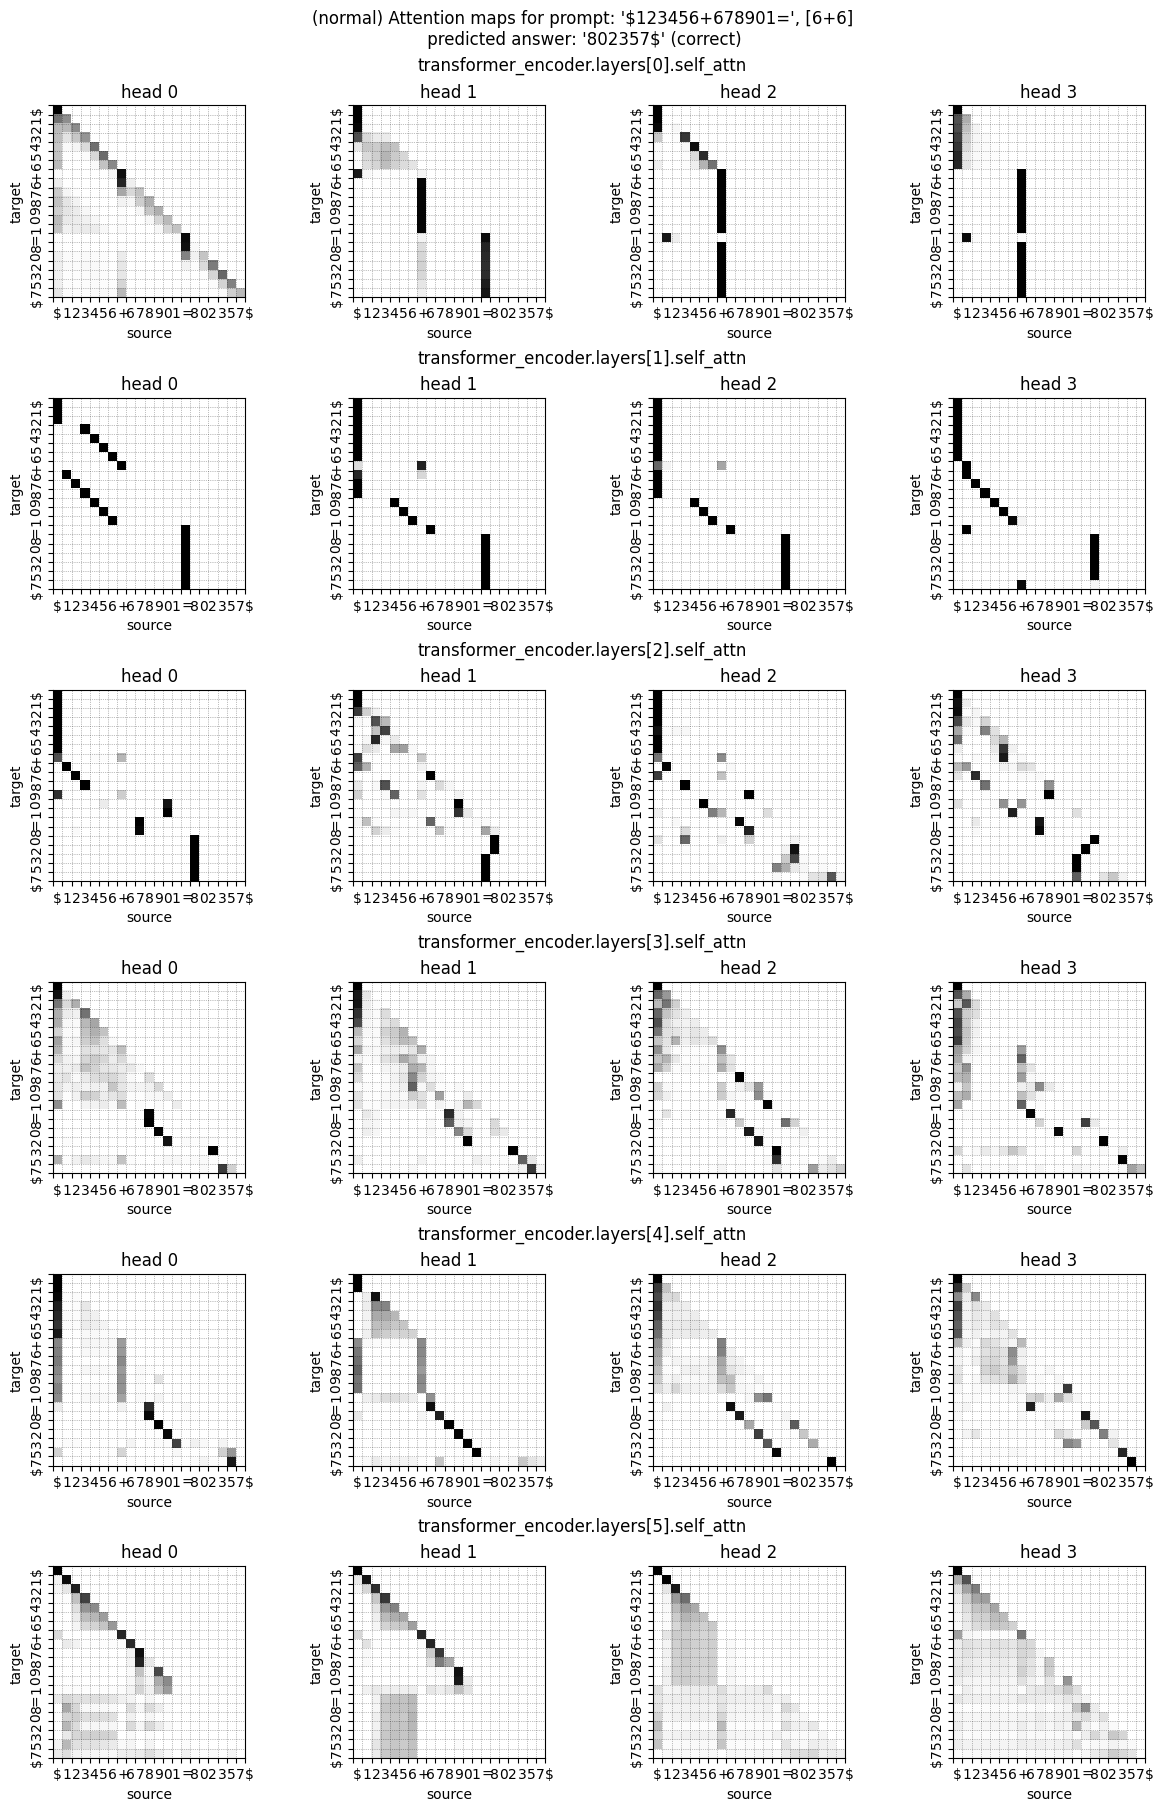

prompt: '$123456+678901=' 6+6
true_ans: 753208
pred_answer: 753208$
transformer_encoder.layers[0].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[1].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[2].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[3].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[4].self_attn torch.Size([1, 4, 21, 21])
transformer_encoder.layers[5].self_attn torch.Size([1, 4, 21, 21])


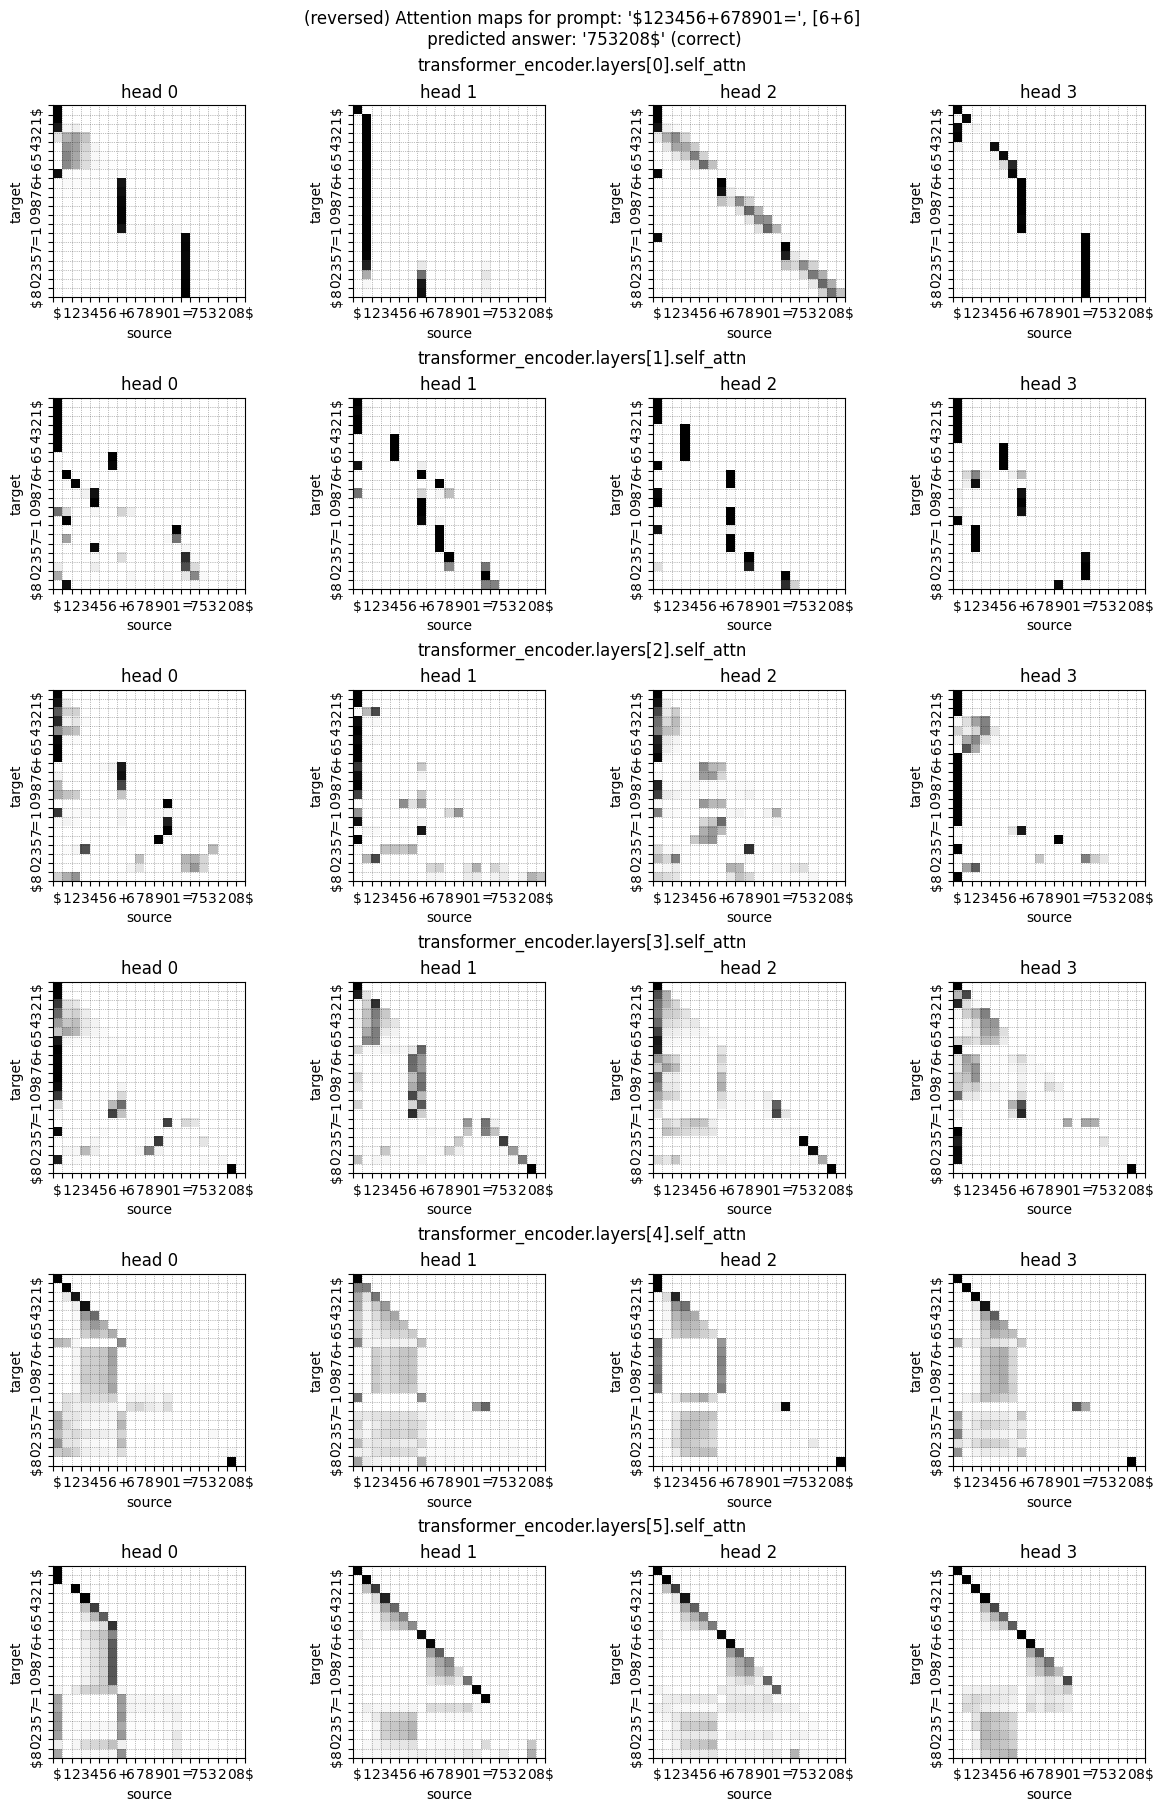

In [7]:
fig_scale = 3

for model_name, ckpt_path in ckpts.items():
    model, hparams = load_model(ckpt_path)
    reverse_ops = hparams["extra_hparams"]["data_format"]["reverse_ops"]
    reverse_ans = hparams["extra_hparams"]["data_format"]["reverse_ans"]
    filler_tokens_prompt = hparams["extra_hparams"]["data_format"][
        "filler_tokens_prompt"
    ]

    module_names = [mn for mn, _ in model.named_modules() if mn.endswith("self_attn")]
    # replace index to get correct syntax
    module_names = [re.sub(r"\.(\d+)\.", r"[\1].", mn) for mn in module_names]

    a, b = 123456, 678901
    savepath = subdir / f"exp15_attn_map_{a}+{b}_{model_name}.png"
    kwargs = dict(
        tokenizer=tokenizer,
        a=a,
        b=b,
        module_names=module_names,
        fig_scale=fig_scale,
        # save=True,
    )
    attn_maps = plot_attn_maps(
        model=model,
        savepath=str(savepath),
        figtitle_prefix=f"({model_name})",
        reverse_ops=reverse_ops,
        reverse_ans=reverse_ans,
        filler_tokens_prompt=filler_tokens_prompt,
        **kwargs,
    )